<a href="https://colab.research.google.com/github/Curovearth/Cell-Segmentation-and-Denoising/blob/main/Cell_Segmentation_and_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **Cell Segmentation and Denoising**

> Project done under the guidance of Dr. Rajini G K ma'am

* Swarup Tripathy [19BEE0167] 
* Mohammad Zayd [19BEI0070]


---

In [1]:
! nvidia-smi    # To check the number of GPUs with their names

Wed Aug 17 05:12:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
print(tf.__version__)

2.8.2


---
## Setup and Importing Libraries

In [3]:
import os
import cv2
import shutil
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

*   `Sequence` → safer way to do multiprocessing. Structure gurantees that the network will only train once on each sample per epoch.

In [4]:
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Add, concatenate, average, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



*   `sklearn.metrics` → module implements several loss, score and utility functions to measure classification performance.
*   `albumentations` → CV tool that boosts the performance of DNN and mainly used for fast and flexible image augmentations.



In [5]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from albumentations import Compose, OneOf, Flip, Rotate, RandomContrast, RandomGamma, RandomBrightness, ElasticTransform, GridDistortion, OpticalDistortion, RGBShift, CLAHE

In [6]:
from albumentations import (Compose, OneOf, 
                            CLAHE, Flip,Rotate,Transpose,ShiftScaleRotate,IAAPiecewiseAffine,RandomRotate90,ChannelShuffle,ElasticTransform,Flip,GridDistortion,HorizontalFlip,HueSaturationValue,OpticalDistortion,
                            RandomBrightnessContrast,RandomGamma,RandomSizedCrop,VerticalFlip,RGBShift,GaussNoise )

Now, we mount our google drive to access the dataset which was downloaded and exported to the drive folder.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
print('---------------------- Directories ----------------------')
for dirname, _, filenames in os.walk('/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data'):
  print(dirname)

---------------------- Directories ----------------------
/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data
/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/masks
/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/test
/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/images


In [9]:
train_image_dir = r'/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/images'
train_mask_dir = r'/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/masks'

In [10]:
train_image_paths = sorted([os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir) if fname.endswith(".png") and not fname.startswith(".")])
train_mask_paths = sorted([os.path.join(train_mask_dir, fname) for fname in os.listdir(train_mask_dir) if fname.endswith(".png") and not fname.startswith(".")])
print("Number of training images : ", len(train_image_paths))
print("Number of training masks : ", len(train_mask_paths))

Number of training images :  670
Number of training masks :  670


In [11]:
# Shuffle
import random
combined = list(zip(train_image_paths, train_mask_paths))
random.shuffle(combined)
train_image_paths[:], train_mask_paths[:] = zip(*combined)

In [12]:
print("After shuffling")
print(train_image_paths[0:5])
print(train_mask_paths[0:5])
# Sequence intact !

After shuffling
['/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/images/414.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/images/262.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/images/100.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/images/231.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/images/663.png']
['/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/masks/414.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/masks/262.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/masks/100.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/masks/231.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/masks/663.png']


In [13]:
# Splitting
train_image_files = train_image_paths[:500]
train_mask_files = train_mask_paths[:500]

valid_image_files = train_image_paths[500:]
valid_mask_files = train_mask_paths[500:]

print(len(train_image_files), len(train_mask_files))
print(len(valid_image_files), len(valid_mask_files))


500 500
170 170


In [14]:
def read_image(file_loc, dim=(256,256)):
    img = Image.open(file_loc)
    img = img.convert('RGB')
    img = img.resize(dim)
    img = np.array(img)
    return img

In [15]:
def read_mask(file_loc, dim=(256,256)):
    img = Image.open(file_loc)
    img = img.resize(dim)
    img = np.array(img)
    img = (img>0).astype(np.uint8)
    return img

In [16]:
class Train_Generator(Sequence):

  def __init__(self, x_set, y_set, batch_size=10, img_dim=(256,256), augmentation=False):
      self.x = x_set
      self.y = y_set
      self.batch_size = batch_size
      self.img_dim = img_dim
      self.augmentation = augmentation

  def __len__(self):
      return math.ceil(len(self.x) / self.batch_size)
# Carefully selected augmentations...works fine with retina...idk abt nucleus !
  aug = Compose(
    [
      CLAHE(always_apply=True, p=1.0), 
      Rotate(always_apply = True,limit=(-360, 360), border_mode=3, p = 1.0),
      Flip(always_apply = True),
      OneOf([
             GaussNoise()
             ], p=0.9),
      OneOf([
             HorizontalFlip()
                 
      ], p=0.6),
      
      OneOf([
             
             RandomBrightnessContrast(),
             RandomGamma()
             ], p=0.2),
     OneOf([VerticalFlip()],p=0.7)
     ,
     OneOf([HueSaturationValue()],p=0.5)
    ])

  def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

      # batch_x = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (512, 512)) for file_name in batch_x])
      # batch_y = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (512, 512)) for file_name in batch_y])
      batch_x = np.array([read_image(file_name, self.img_dim) for file_name in batch_x])
      batch_y = np.array([read_mask(file_name, self.img_dim) for file_name in batch_y])

      if self.augmentation is True:
        aug = [self.aug(image=i, mask=j) for i, j in zip(batch_x, batch_y)]
        batch_x = np.array([i['image'] for i in aug])
        batch_y = np.array([j['mask'] for j in aug])

      batch_y = np.expand_dims(batch_y, -1)

      return batch_x/255.0, batch_y/1.0
  

In [17]:
class Val_Generator(Sequence):

  def __init__(self, x_set, y_set, batch_size=10, img_dim=(256,256), augmentation=False):
      self.x = x_set
      self.y = y_set
      self.batch_size = batch_size
      self.img_dim = img_dim
      self.augmentation = augmentation

  def __len__(self):
       k=math.ceil(len(self.x) / self.batch_size)
      #  print(k)
      #  print(len(self.x))
      #  print(self.batch_size)
       return math.ceil(len(self.x) / self.batch_size)

  aug = Compose(
    [
      CLAHE(always_apply=True, p=1.0)
    ])


  def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
      # print(batch_x)
      # print(batch_y)

      # batch_x = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (512, 512)) for file_name in batch_x])
      # batch_y = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (512, 512)) for file_name in batch_y])
      batch_x = np.array([read_image(file_name, self.img_dim) for file_name in batch_x])
      batch_y = np.array([read_mask(file_name, self.img_dim) for file_name in batch_y])

      if self.augmentation is True:
        aug = [self.aug(image=i, mask=j) for i, j in zip(batch_x, batch_y)]
        batch_x = np.array([i['image'] for i in aug])
        batch_y = np.array([j['mask'] for j in aug])
      batch_y = np.expand_dims(batch_y, -1)

      return batch_x/255.0, batch_y/1.0
  

In [18]:
train_generator = Train_Generator(train_image_files, train_mask_files)
valid_generator = Val_Generator(valid_image_files, valid_mask_files)

In [19]:
# Finally in 3 dims

for i, j in train_generator:
  print(i.dtype)
  print(j.dtype)
  break

float64
float64


In [20]:
for i, j in train_generator:
  print(i.shape)
  print(j.shape)
  break

(10, 256, 256, 3)
(10, 256, 256, 1)


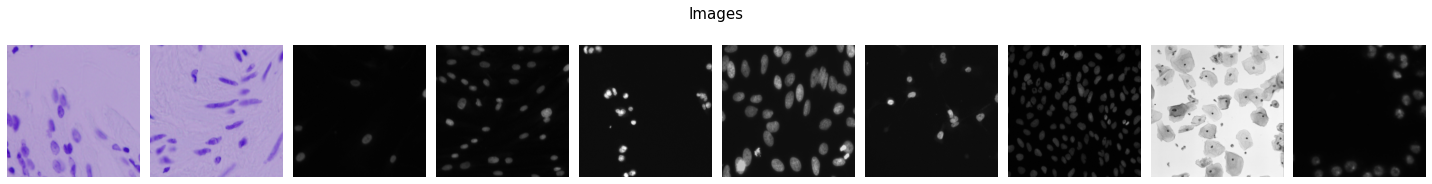

In [21]:
fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:10], axes[:10]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()


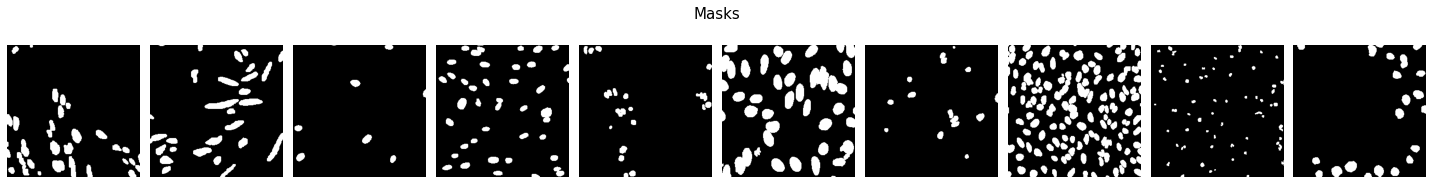

In [22]:

fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:10], axes[:10]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [23]:
def train_generator():
  return Train_Generator(train_image_files, train_mask_files, augmentation=True)
def valid_generator():
  return Val_Generator(valid_image_files, valid_mask_files, augmentation=True)


In [24]:
ds_train = tf.data.Dataset.from_generator(
    train_generator, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([None,256,256,3], [None,256,256,1])
).repeat()

ds_valid = tf.data.Dataset.from_generator(
    valid_generator, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([None,256,256,3], [None,256,256,1])
).repeat()

In [25]:
 train_generator_aug = Train_Generator(train_image_files, train_mask_files,augmentation=True)

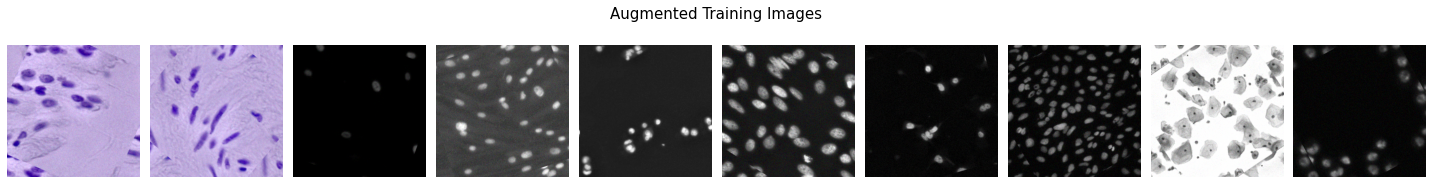

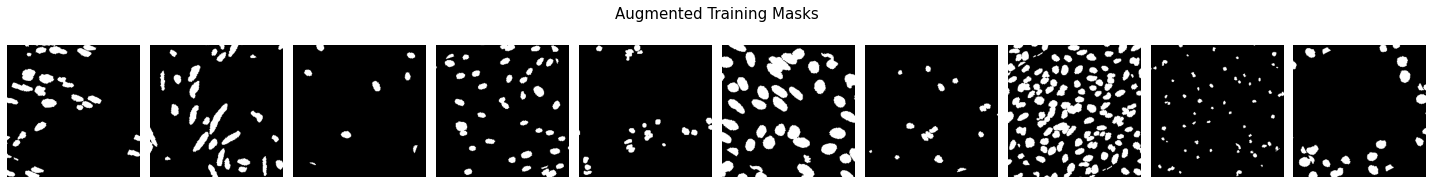

In [26]:
# Augmented training set
for i, j in ds_train:
    break

fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Augmented Training Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:10], axes[:10]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Augmented Training Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:10], axes[:10]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [27]:
 valid_generator_aug= Val_Generator(valid_image_files, valid_mask_files,augmentation=True)

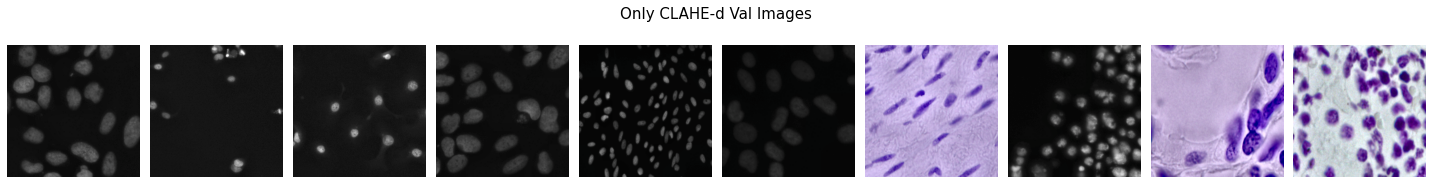

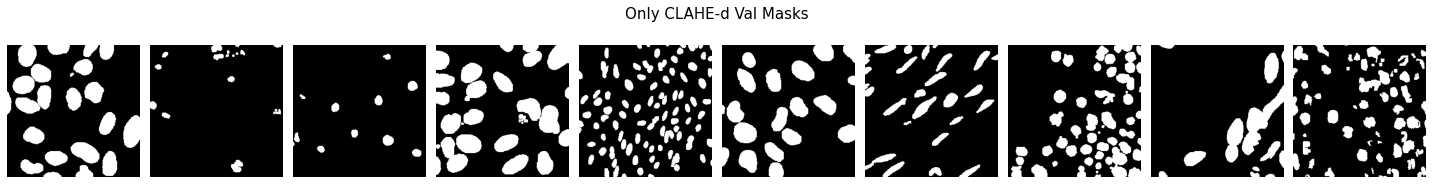

In [28]:
# Augmented val set
for i, j in ds_valid:
    break

fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Only CLAHE-d Val Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:10], axes[:10]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Only CLAHE-d Val Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:10], axes[:10]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [29]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = y_true * y_pred
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def iou(y_true, y_pred):
    thresh = 0.5
    smooth = 1.
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    y_true = K.cast(K.greater_equal(y_true, thresh), 'float32')
    y_pred = K.cast(K.greater_equal(y_pred, thresh), 'float32')
    intersection = K.sum(K.minimum(y_true, y_pred)) + smooth
    union = K.sum(K.maximum(y_true, y_pred)) + smooth
    iou = intersection/union
    return iou

In [30]:
def nested_unet():

  inputs = Input((256,256, 3))

  A_conv_0 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_0') (inputs)
  A_conv_0 = BatchNormalization() (A_conv_0)
  A_conv_0 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_0_1') (A_conv_0)
  A_conv_0 = BatchNormalization() (A_conv_0)
  A_pool_0 = MaxPooling2D((2, 2)) (A_conv_0)

  B_conv_0 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='B_conv_0') (A_pool_0)
  B_conv_0 = BatchNormalization() (B_conv_0)
  B_conv_0 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='B_conv_0_1') (B_conv_0)
  B_conv_0 = BatchNormalization() (B_conv_0)
  B_pool_0 = MaxPooling2D((2, 2)) (B_conv_0)

  C_conv_0 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='C_conv_0') (B_pool_0)
  C_conv_0 = BatchNormalization() (C_conv_0)
  C_conv_0 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='C_conv_0_1') (C_conv_0)
  C_conv_0 = BatchNormalization() (C_conv_0)
  C_pool_0 = MaxPooling2D((2, 2)) (C_conv_0)

  D_conv_0 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='D_conv_0') (C_pool_0)
  D_conv_0 = BatchNormalization() (D_conv_0)
  D_conv_0 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='D_conv_0_1') (D_conv_0)
  D_conv_0 = BatchNormalization() (D_conv_0)
  D_pool_0 = MaxPooling2D((2, 2)) (D_conv_0)

  E_conv_0 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='E_conv_0') (D_pool_0)
  E_conv_0 = BatchNormalization() (E_conv_0)
  E_conv_0 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='E_conv_0_1') (E_conv_0)
  E_conv_0 = BatchNormalization() (E_conv_0)
  E_pool_0 = MaxPooling2D((2, 2)) (E_conv_0)

  #-------------------------------------------------------------------------------------------------------------#

  A_conv_1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='A_trans_1') (B_conv_0)
  A_conv_1 = concatenate([A_conv_0, A_conv_1], name='A_concat_1')
  A_conv_1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_1') (A_conv_1)
  A_conv_1 = BatchNormalization() (A_conv_1)

  B_conv_1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='B_trans_1') (C_conv_0)
  B_conv_1 = concatenate([B_conv_0, B_conv_1], name='B_concat_1')
  B_conv_1 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='B_conv_1') (B_conv_1)
  B_conv_1 = BatchNormalization() (B_conv_1)

  C_conv_1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='C_trans_1') (D_conv_0)
  C_conv_1 = concatenate([C_conv_0, C_conv_1], name='C_concat_1')
  C_conv_1 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='C_conv_1') (C_conv_1)
  C_conv_1 = BatchNormalization() (C_conv_1)

  D_conv_1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='D_trans_1') (E_conv_0)
  D_conv_1 = concatenate([D_conv_0, D_conv_1], name='D_concat_1')
  D_conv_1 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='D_conv_1') (D_conv_1)
  D_conv_1 = BatchNormalization() (D_conv_1)

  #-------------------------------------------------------------------------------------------------------------#

  A_conv_2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='A_trans_2') (B_conv_1)
  A_conv_2 = concatenate([A_conv_0, A_conv_1, A_conv_2], name='A_concat_2')
  A_conv_2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_2') (A_conv_2)
  A_conv_2 = BatchNormalization() (A_conv_2)

  B_conv_2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='B_trans_2') (C_conv_1)
  B_conv_2 = concatenate([B_conv_0, B_conv_1, B_conv_2], name='B_concat_2')
  B_conv_2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='B_conv_2') (B_conv_2)
  B_conv_2 = BatchNormalization() (B_conv_2)

  C_conv_2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='C_trans_2') (D_conv_1)
  C_conv_2 = concatenate([C_conv_0, C_conv_1, C_conv_2], name='C_concat_2')
  C_conv_2 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='C_conv_2') (C_conv_2)
  C_conv_2 = BatchNormalization() (C_conv_2)

  #-------------------------------------------------------------------------------------------------------------#

  A_conv_3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='A_trans_3') (B_conv_2)
  A_conv_3 = concatenate([A_conv_0, A_conv_1, A_conv_2, A_conv_3], name='A_concat_3')
  A_conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_3') (A_conv_3)
  A_conv_3 = BatchNormalization() (A_conv_3)

  B_conv_3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='B_trans_3') (C_conv_2)
  B_conv_3 = concatenate([B_conv_0, B_conv_1, B_conv_2, B_conv_3], name='B_concat_3')
  B_conv_3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='B_conv_3') (B_conv_3)
  B_conv_3 = BatchNormalization() (B_conv_3)

  #-------------------------------------------------------------------------------------------------------------#

  A_conv_4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='A_trans_4') (B_conv_3)
  A_conv_4 = concatenate([A_conv_0, A_conv_1, A_conv_2, A_conv_3, A_conv_4], name='A_concat_4')
  A_conv_4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_4') (A_conv_4)
  A_conv_4 = BatchNormalization() (A_conv_4)

  #-------------------------------------------------------------------------------------------------------------#

  A_out_1 = Conv2D(1, (1, 1), activation='sigmoid',name='out1') (A_conv_1)
  A_out_2 = Conv2D(1, (1, 1), activation='sigmoid',name='out2') (A_conv_2)
  A_out_3 = Conv2D(1, (1, 1), activation='sigmoid',name='out3') (A_conv_3)
  A_out_4 = Conv2D(1, (1, 1), activation='sigmoid',name='out4') (A_conv_4)

  outputs = average([A_out_1, A_out_2, A_out_3, A_out_4])

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

model = nested_unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 A_conv_0 (Conv2D)              (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['A_conv_0[0][0]']               
 alization)                     )                                                             

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler